<a href="https://colab.research.google.com/github/mannixp/CHIST/blob/main/PDF_Construction_using_extruded_mesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get update --fix-missing

try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

**Numerical functions**

In many applications we have do not have access to an analytic functions $Y(\boldsymbol{x})$, but rather we have the ability to evaluate them at an arbitrary set of quadrature points $\{\boldsymbol{x}_q\}$. Given that our approach to computing CDF the of $Y(\boldsymbol{x})$
\begin{equation*}
    F(y) = \int_{\Omega} \mathbb{I}(y,\boldsymbol{x}) d \boldsymbol{x},
\end{equation*}
utilises numerical quadrature in order to evaluate a projection of the indicator function given by
\begin{equation*}
    \mathbb{I}(y,\boldsymbol{x}) =
    \begin{cases}
    1 \quad &: Y(\boldsymbol{x}) < y, \\
    0 \quad &: \text{otherwise},
    \end{cases}
\end{equation*}
this implies that by using a sufficiently high degree of numerical quadrature we can exploit the functional form of $Y(\boldsymbol{x})$. In instances where the function is calculated using a psuedo-spectral or finite element method this is therefore particularly powerful.

In this notebook we consider three different examples. The first demonstrates the convergence of our method while the second and third examples show how to calculate the CDF from externally generated data. To begin implementing these examples we first import *firedrake* and *Ptp*.

In [1]:
from chist import Ptp
from firedrake import *
import matplotlib.pyplot as plt 

**Example 1: Trignometric function**

As a first example we consider the function
\begin{equation}
Y(X) = \cos(X), \quad X \in [0, 2\pi).
\end{equation}
This function has the analytic pdf, cdf and qdf given by
\begin{equation}
f(y) = \frac{1}{\pi \sqrt{1 - y^2}}, \quad F(y) = 1 - \arccos(y)/\pi, \quad Q(y) = \cos(\pi(1-y)),
\end{equation}
respectively and can thus be used to assess the convergence of the routines our method provides. Below we set up functions for these analytic expression.

In [2]:
F = lambda y: 1 - acos(y)/np.pi
f = lambda y: 1/(np.pi*(1-y**2)**.5)
Q = lambda y: cos(np.pi*(1-y))

Varying the number of elements used we then compute compute the $L^2$ error norm between the numerical estimation provided by our method and its analytical expression
\begin{equation}
||f_{num} - f||_2 = \int_{\Omega} |f_{num}(y) -f(y)|^2 dy
\end{equation}
This is done by choosing a large quadrature degree such that the number of elements used becomes the leading order error.

In [3]:
error_cdf = []
error_pdf = []
error_qdf = []
Ne = [4, 8, 16, 32, 64, 128]

def L2_norm(f):
    """Norm for computing the error."""
    return assemble( (f**2)*dx )

for ne in Ne:

    # Compute the density object
    ptp = Ptp(Omega_X={'x1': (0, 2*np.pi)}, Omega_Y={'Y': (-1, 1)}, n_elements=ne)
    x1 = ptp.x_coords()
    density = ptp.fit(Y=cos(x1), quadrature_degree=5000)
    
    # Compute the error for the cdf, pdf, qdf
    error_cdf.append( L2_norm(density.cdf - F(density.y)) )
    error_pdf.append( L2_norm(density.pdf - f(density.y)) )
    p = SpatialCoordinate(density.qdf.function_space().mesh())[0]
    error_qdf.append( L2_norm(density.qdf - Q(p)) )

Ne = np.asarray(Ne)
error_cdf = np.asarray(error_cdf)
error_pdf = np.asarray(error_pdf)
error_qdf = np.asarray(error_qdf)

Below we plot the rate of convergence, which for both the cdf and qdf is close to the theoretical estimate 
\begin{equation}
||f_{num} - f||_2 \sim \mathcal{O}(N_e^{-(\alpha + 1)})
\end{equation}
which for a piecewise linear function space we take $\alpha=1$. When a larger number of elements is used the slope reduces as errors due to quadrature become leading order. Due to the singularities present in $f(y)$ at $y \pm 1$ this rate of convergence is not established for the pdf. However, as we now show, when the domain of the function $Y(x)$ is changed in order to avoid these singularities convergence of the pdf is also obtained. 

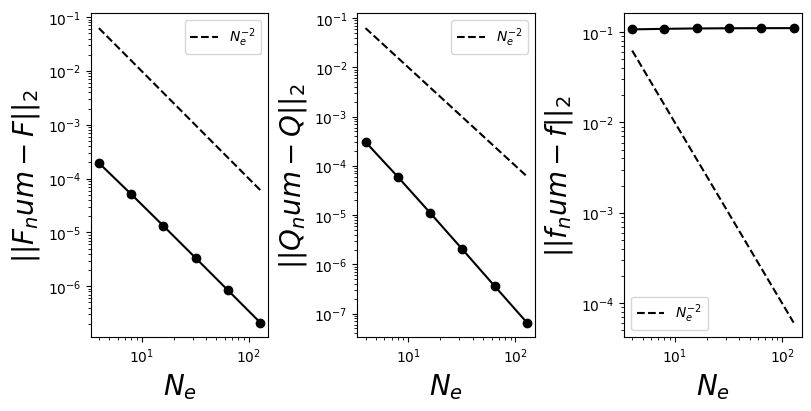

In [4]:
import matplotlib.pyplot as plt
from firedrake.pyplot import plot

# Theoretical convergence ~ O(N^2)
error = np.asarray([1./np.pow(n,2) for n in Ne ])

# Plot the convergence of the error
fig,ax = plt.subplots(nrows=1, ncols=3, figsize=(8,4), layout='constrained')

# CDF
ax[0].loglog(Ne,error_cdf,'k-')
ax[0].loglog(Ne,error_cdf,'ko')
ax[0].loglog(Ne,error    ,'k--',label=r'$N_e^{-2}$')
ax[0].set_ylabel(r'$||F_num - F||_2$',fontsize=20)
ax[0].set_xlabel(r'$N_e$',fontsize=20)
ax[0].legend()

# QDF
ax[1].loglog(Ne,error_qdf,'k-')
ax[1].loglog(Ne,error_qdf,'ko')
ax[1].loglog(Ne,error    ,'k--',label=r'$N_e^{-2}$')
ax[1].set_ylabel(r'$||Q_num - Q||_2$',fontsize=20)
ax[1].set_xlabel(r'$N_e$',fontsize=20)
ax[1].legend()

# PDF
ax[2].loglog(Ne,error_pdf,'k-')
ax[2].loglog(Ne,error_pdf,'ko')
ax[2].loglog(Ne,error    ,'k--',label=r'$N_e^{-2}$')
ax[2].set_ylabel(r'$||f_num - f||_2$',fontsize=20)
ax[2].set_xlabel(r'$N_e$',fontsize=20)
ax[2].legend()

plt.show()

Recomputing our numerical estimate of the pdf of $Y(X) = \cos(X)$ for $X \in [\pi/4, 3 \pi/4 ]$ such that the range of $Y$ becomes $[-1/\sqrt{2},1/\sqrt{2}]$, we confirm that our method for estimating the pdf also produces the correct convergence.

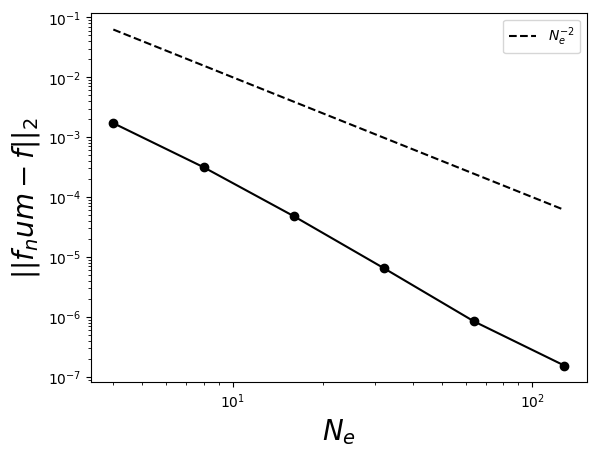

In [5]:
error_pdf = []
Ne = [4, 8, 16, 32, 64, 128]

def L2_norm(f):
    """Norm for computing the error."""
    return assemble( (f**2)*dx )

for ne in Ne:

    # Compute the density object
    ptp = Ptp(Omega_X={'x1': (np.pi/4, 3*np.pi/4)}, Omega_Y={'Y': (-1/2**.5, 1/2**.5)}, n_elements=ne)
    x1 = ptp.x_coords()
    density = ptp.fit(Y=cos(x1), quadrature_degree=8000)
    
    # Compute the error for the cdf, pdf, qdf
    error_pdf.append( L2_norm(density.pdf - 2*f(density.y)) )
    

Ne = np.asarray(Ne)
error_pdf = np.asarray(error_pdf)

# Theoretical convergence ~ O(N^2)
error = np.asarray([1./np.pow(n,2) for n in Ne ])

plt.loglog(Ne,error_pdf,'k-')
plt.loglog(Ne,error_pdf,'ko')
plt.loglog(Ne,error    ,'k--',label=r'$N_e^{-2}$')
plt.ylabel(r'$||f_num - f||_2$',fontsize=20)
plt.xlabel(r'$N_e$',fontsize=20)
plt.legend()
plt.show()

**Example 2: Lorenz model**

As a second example we consider the function 
\begin{equation}
Y(\boldsymbol{X})  = \frac{\sqrt{2}}{\pi r} \cos(k X_1) \sin( \pi X_2) - \frac{1}{ r \pi} \sin(2 \pi X_2),
\end{equation}
corresponding to the buoyancy field used in the Lorenz (1963) model, for which we set the parameters $r=28, k = \pi/\sqrt{2}$. We implement this below in terms of numpy arrays

In [6]:
import numpy as np

# Parameters
r = 28 
k = np.pi/2**.5

def Y_numerical(X):
    """Return Y(X)."""
    x1, x2 = X[:,0], X[:,1]
    return ( 2**.5/(np.pi*r) ) * np.cos(k*x1) * np.sin(np.pi*x2) - ( 1/(np.pi*r) ) * np.sin(2*np.pi*x2)

which is then visualised below on a grid to establish the range of $Y(\boldsymbol{X})$.

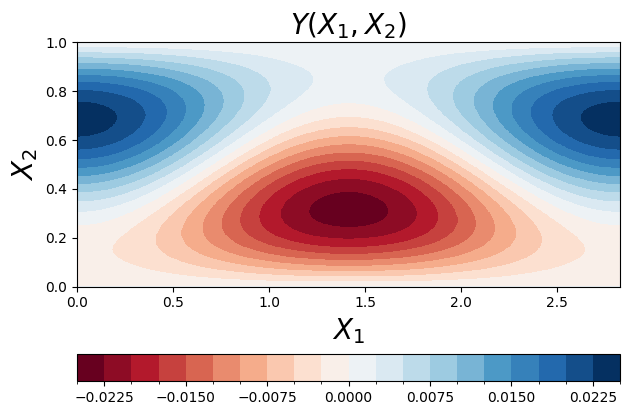

In [7]:
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

x = np.linspace(0, 2*np.pi/k, 10**3)
z = np.linspace(0, 1, 10**3)
[x1, x2] = np.meshgrid(x,z, indexing='ij')

X = np.vstack( (x1.flatten(), x2.flatten())).T
Y = Y_numerical(X).reshape(x2.shape)[:-1, :-1]

levels = MaxNLocator(nbins=20).tick_values(Y.min(), Y.max())
cmap = plt.get_cmap('RdBu')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, ax0 = plt.subplots()
im = ax0.pcolormesh(x1, x2, Y, cmap=cmap, norm=norm)
ax0.set_title(r'$Y(X_1,X_2)$',fontsize=20)
ax0.set_xlabel(r'$X_1$',fontsize=20)
ax0.set_ylabel(r'$X_2$',fontsize=20)
ax0.set_box_aspect(1/k)
fig.colorbar(im, ax=ax0, orientation='horizontal')
fig.tight_layout()
plt.show()

To approximate the cdf of $Y(\boldsymbol{X})$ using CHIST we first create a *Ptp* object by specifying the domain and range of the function.

In [8]:
y_min = -2/(np.pi*r)
y_max =  2/(np.pi*r)
ptp = Ptp(Omega_X={'x1': (0, np.pi/k), 'x2': (0, 1)}, Omega_Y={'Y': (y_min, y_max)}, n_elements=200)

We can then pass *Y_numerical* directly to *ptp.fit()* which identifies it as a python callable. This method can then evaulate $Y(\boldsymbol{X})$ on a *Quadrature Element* using a number of points directly determined by the *quadrature_degree* parameter.

In [9]:
density = ptp.fit(Y_numerical, quadrature_degree=1000)

To verify that our computations are correct in two dimensions we can "compare" the estimated CDF with the analytical CDF whose calculation and details are outlined in the appendix of [Craske J., & Mannix P. (2024)](https://arxiv.org/abs/2408.08028). Unlike for the 1D case however, where $Y$ had a known density, in two dimensions $Y(\boldsymbol{X})$ is a function of two variables and thus does not have a unique inverse. As such this comparison is not suitable to establish convergence.

The plot below shows that for both the pdf and cdf our method's prediction closely matches the analytical estimate, despite the presence of singularities.


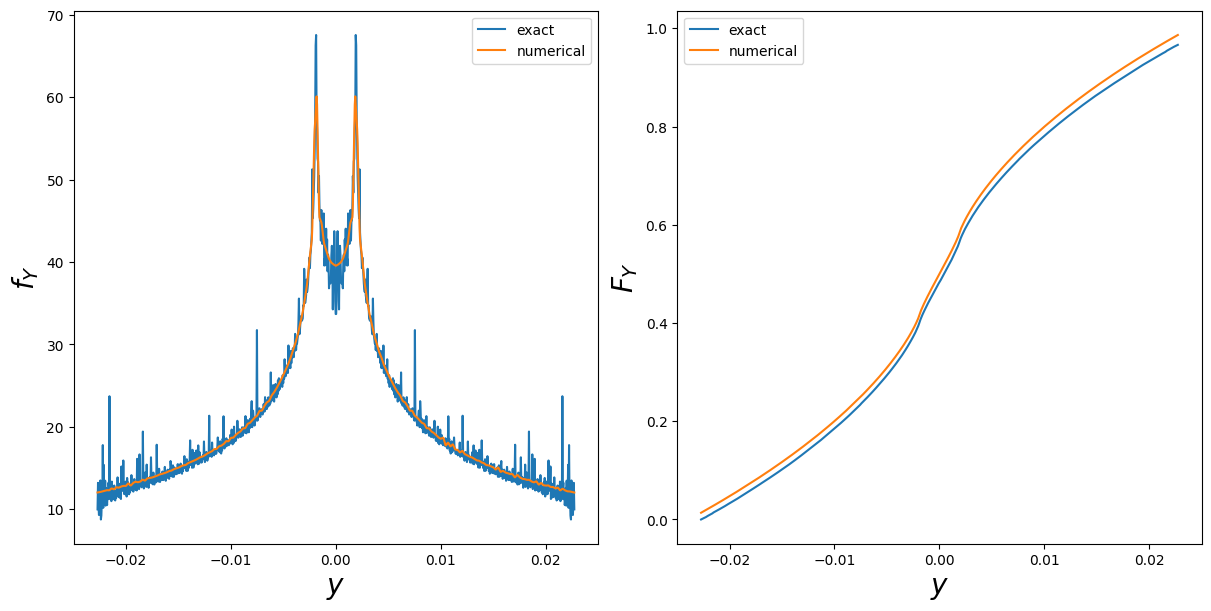

In [10]:
def lorenz_density(n=10**3):
    """
    Return f_Y2,F_Y2 of the system

    Y1 = c0.a0(t).cos(k.X1).sin(pi.X2)
    Y2 = c1.a1(t).cos(k.X1).sin(pi.X2) - c2.a2(t).sin(pi.X2).cos(pi.X2) 
    
    following the methods outlined in Appendix B of Craske J. & Mannix P. (2024).
    """

    import helper as lorenz

    # Obtain the coefficients
    a = np.ones(3)
    c = lorenz.calc_coeffs()
    scale = 1-1e-03

    # Set bounds for the domain of PDF f
    y1_min = -np.sign(a[0])*c[0]*a[0]
    y1_max =  np.sign(a[0])*c[0]*a[0]
    y2_min = -(c[1]/np.sqrt(2)*a[1]/a[0] + c[2]/2*a[2])
    y2_max = c[1]/np.sqrt(2)*a[1]/a[0] + c[2]/2*a[2]

    y1_ = np.linspace(scale*y1_min, scale*y1_max, n)
    y2_ = np.linspace(scale*y2_min, scale*y2_max, n)

    # Y-domain for PDF
    # Calculate the jacobian in terms of y1 and y2
    [y1,y2] = np.meshgrid(y1_,y2_, indexing='ij')
    f_Y1Y2 = lorenz.calc_jac([y1, y2], a)

    f_Y1Y2[f_Y1Y2 > 10**3] = 0

    # Compute the marginal PDF f_Y2 = int f_Y1,Y2(y1,y2) dy2
    from scipy.integrate import cumulative_trapezoid, trapezoid
    from copy import deepcopy
    y = deepcopy(y2_)
    f = trapezoid(y=f_Y1Y2,x=y1_,axis=0)
    F = cumulative_trapezoid(y=f,x=y,initial=0)

    return f,F,y

# Obtain the semi-analytical denisty
f,F,y = lorenz_density(n=(10**3))

# Obtain the ptp estimate of the density
F_num = np.asarray(density.cdf.at(y))
f_num = np.asarray(density.pdf.at(y))

# Comapre the analytical and estimated density
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), layout='constrained')

ax[0].plot(y,f,label='exact')
ax[0].plot(y,f_num,label='numerical')
ax[0].set_ylabel(r'$f_Y$',fontsize=20)
ax[0].set_xlabel(r'$y$',fontsize=20)
ax[0].legend()

ax[1].plot(y,F,label='exact')
ax[1].plot(y,F_num,label='numerical')
ax[1].set_ylabel(r'$F_Y$',fontsize=20)
ax[1].set_xlabel(r'$y$',fontsize=20)
ax[1].legend()

plt.show()


**Example 3: Kelvin-Helmholtz instability**

For the third example we will compute the cdf of the density field $\rho(\boldsymbol{X})$ of a time evolving simulation of the Kelvin-Helmholtz instability generated using [Dedalus](https://dedalus-project.org/). The dataset we use contains snapshots at $T=[10,15,20]$. Following the previous example we write a function *Y_numerical* which returns the value of the function at a set of quadrature points

In [11]:
import h5py
from scipy.interpolate import RegularGridInterpolator

Times = [10 ,15 ,20]

def Y_numerical(X, time=2):
    """Return Y(X)."""

    f = h5py.File('data/KelvinHelmholtz/snapshots_s1.h5','r')
    Y = f['tasks/buoyancy'][time, ...]
    x = f['tasks/buoyancy'].dims[1][0][:]
    z = f['tasks/buoyancy'].dims[2][0][:]
    f.close()

    return RegularGridInterpolator((x, z), Y, bounds_error=False)(X)

Using *Y_numerical* we then plot snapshots of this data at different time-instants on a regular grid

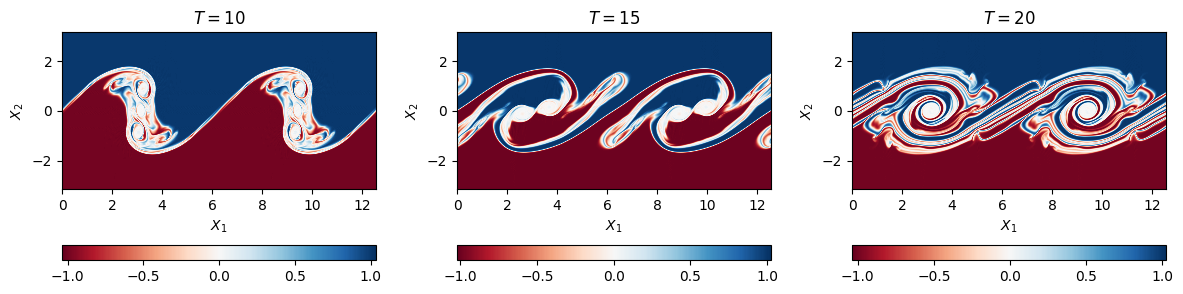

In [12]:
dx1, dx2 = 0.01, 0.01
x2, x1 = np.mgrid[slice(-np.pi,np.pi + dx1, dx1), slice(0, 4*np.pi + dx2, dx2)]
X = np.vstack( (x1.flatten(), x2.flatten())).T

fig, ax = plt.subplots(ncols=3,figsize=(12,4))

for ax0,time in zip(ax, Times):

    Y = Y_numerical(X,time).reshape(x2.shape)[:-1, :-1]

    cmap = plt.get_cmap('RdBu')
    im = ax0.pcolormesh(x1, x2, Y, cmap=cmap)
    ax0.set_title(r'$T=%d$'%time)
    ax0.set_xlabel(r'$X_1$')
    ax0.set_ylabel(r'$X_2$')
    ax0.set_box_aspect(0.5)
    fig.colorbar(im, ax=ax0, orientation='horizontal')

fig.tight_layout()
plt.show()

To generate the CDF of this field we create a *Ptp* object which specifies the domain size, the function's range and the number of finite elements.

In [13]:
ptp = Ptp(Omega_X={'x1': (0, 4*np.pi), 'x2': (-np.pi, np.pi)}, Omega_Y={'Y': (-1, 1)}, n_elements=200)

We then create a *density* object by selecting the quadrature degree and calling the fit method on each snapshot

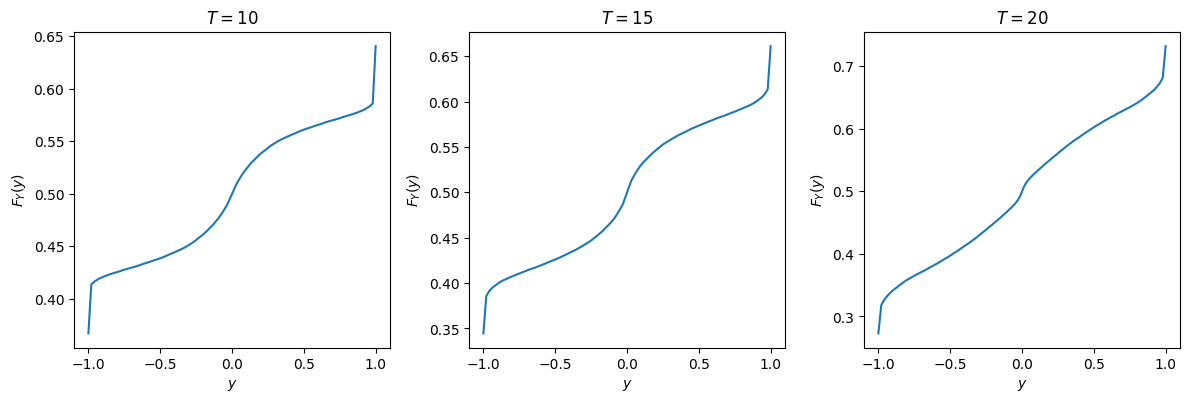

In [14]:

fig, ax = plt.subplots(ncols=3,figsize=(12,4))

y = np.linspace(-1, 1, 10**2)

for ax0,time in zip(ax, Times):

    Y = lambda X: Y_numerical(X,time=time)
    density = ptp.fit(Y, quadrature_degree=1000)

    F = np.asarray(density.cdf.at(y))
    ax0.plot(y,F)
    ax0.set_title(r'$T=%d$'%time)
    ax0.set_xlabel(r'$y$')
    ax0.set_ylabel(r'$F_Y(y)$')
    ax0.set_box_aspect(1)

fig.tight_layout()
plt.show()